# Transfer learning and fine tuning for image classification#

# Importing the libraries

In [ ]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model # for combining the base model NN and the custom NN
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
tf.__version__

'2.15.0'


# Loading the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/Transfer learning and fine tuning for image classification/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

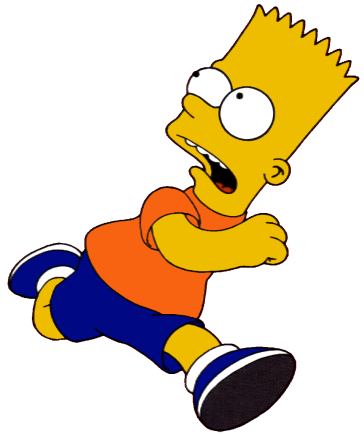

In [5]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

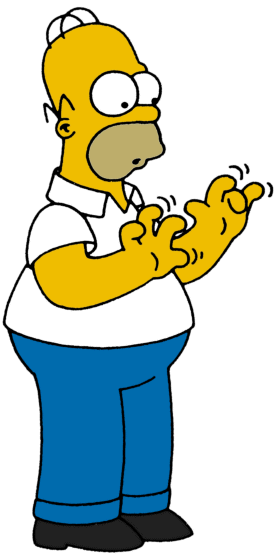

In [6]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')

# Train and test set

In [7]:
# We can configure some parameters to make modifications to the original images.
# This is very useful when we have few images of each class.
# As you can see here, there are many other parameters that can be configured.
# Using this function, in addition to the original images, we will also have new images
# with application of these pre-processing
training_generator = ImageDataGenerator(rescale=1./255, # normalizeing the data
                                        rotation_range=7, # number of rotation image can go
                                        horizontal_flip=True, # flipping the image horizontally
                                        zoom_range=0.2) # decrease or increase the zoom. needed for new image gen

# As the name suggests, this parameter will mix the images,
# they will be accessed in a completely random order to prevent the neural network
# from memorizing the order of the images. Otherwise, the neural network could
# learn the order of the images and not their features
train_dataset = training_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                        target_size = (256, 256), # required shape we want for our image
                                                        batch_size = 8, # images would be acceses in sets of 8
                                                        class_mode = 'categorical', # binary can be used but only one neuron in the output layer
                                                       shuffle = True) # helps prevent the NN from memorizing the image instead of learning the features.

Found 215 images belonging to 2 classes.


In [8]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [9]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [10]:
# To test, we set this parameter to FALSE because when testing,
# the order of the images makes no difference.
# If we leave the value equals TRUE, we will not be able to associate the
# predictions with the expected outputs
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                                     target_size = (256, 256), # required shape we want for our image
                                                     batch_size = 1, # images would be acceses in sets of 1
                                                     class_mode = 'categorical', # binary can be used but only one neuron in the output layer
                                                     shuffle = False) # order of images has no difference, so we leave it as False

Found 54 images belonging to 2 classes.


# Pre-trained network

[RestNet:](https://arxiv.org/pdf/1512.03385.pdf)

[Documentation:](https://keras.io/api/applications/)

In [11]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 [==============================] - 1s 0us/step


In [12]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [13]:
len(base_model.layers)

175

In [14]:
for layer in base_model.layers:
  layer.trainable = False

In [15]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x78a62e176aa0> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78a62e1e8f70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a62e1e9270> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78a62e1e9f00> False
<keras.src.layers.core.activation.Activation object at 0x78a62e1e9780> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78a62e1eab90> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78a61f7341f0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a61f735ea0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78a61f735cf0> False
<keras.src.layers.core.activation.Activation object at 0x78a61f734130> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a61f7372b0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization

# Custom dense layer

In [16]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [17]:
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

# Building and training the neural network

In [18]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [19]:
CNN = Model(inputs = base_model.input, outputs = head_model)

In [20]:
8 * 8 * 2048

131072

In [21]:
(2048 + 2) / 2

1025.0

In [22]:
CNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [23]:
CNN.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [64]:
history = CNN.fit_generator(train_dataset, epochs=50)

<ipython-input-64-2ae25d0f6917>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNN.fit_generator(train_dataset, epochs=50)


Epoch 1/50
27/27 [==============================] - 6s 218ms/step - loss: 0.1850 - accuracy: 0.9209
Epoch 2/50
27/27 [==============================] - 4s 128ms/step - loss: 0.2587 - accuracy: 0.9116
Epoch 3/50
27/27 [==============================] - 4s 151ms/step - loss: 0.1895 - accuracy: 0.9256
Epoch 4/50
27/27 [==============================] - 3s 125ms/step - loss: 0.2228 - accuracy: 0.9163
Epoch 5/50
27/27 [==============================] - 3s 124ms/step - loss: 0.1261 - accuracy: 0.9535
Epoch 6/50
27/27 [==============================] - 5s 174ms/step - loss: 0.2380 - accuracy: 0.9070
Epoch 7/50
27/27 [==============================] - 3s 126ms/step - loss: 0.2005 - accuracy: 0.9116
Epoch 8/50
27/27 [==============================] - 3s 125ms/step - loss: 0.1540 - accuracy: 0.9535
Epoch 9/50
27/27 [==============================] - 4s 150ms/step - loss: 0.1769 - accuracy: 0.9535
Epoch 10/50
27/27 [==============================] - 4s 143ms/step - loss: 0.2064 - accuracy: 0.9209

# Evaluating the neural network

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

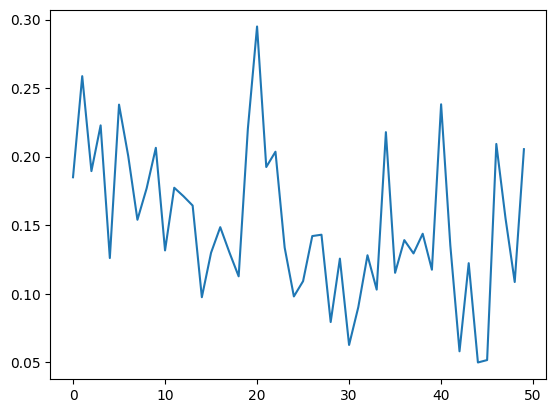

In [67]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss']);

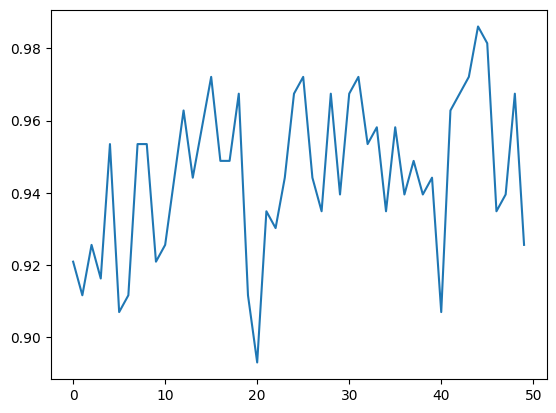

In [68]:
plt.plot(history.history['accuracy']);

# Testing the Convolutional NN on test data set

In [69]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [74]:
predictions = CNN.predict(test_dataset)
predictions

54/54 [==============================] - 1s 11ms/step


array([[1.0000000e+00, 2.1217776e-08],
       [1.0000000e+00, 2.0094622e-10],
       [8.3037563e-02, 9.1696244e-01],
       [1.0000000e+00, 4.7761874e-11],
       [9.9999976e-01, 1.9912331e-07],
       [9.9999952e-01, 4.3895295e-07],
       [9.9889094e-01, 1.1090888e-03],
       [9.6680284e-01, 3.3197165e-02],
       [9.9996781e-01, 3.2227999e-05],
       [9.9992597e-01, 7.4025964e-05],
       [4.4633842e-01, 5.5366153e-01],
       [1.0000000e+00, 5.9314307e-12],
       [9.9999988e-01, 8.0252406e-08],
       [9.9981731e-01, 1.8274067e-04],
       [9.9986422e-01, 1.3581911e-04],
       [1.0000000e+00, 2.3637518e-12],
       [1.0000000e+00, 4.4799446e-08],
       [9.9990511e-01, 9.4855452e-05],
       [1.0000000e+00, 1.9481576e-10],
       [1.0000000e+00, 4.9806258e-13],
       [9.9999595e-01, 4.0728505e-06],
       [1.0000000e+00, 4.1877030e-10],
       [1.0000000e+00, 4.6558907e-12],
       [9.9999988e-01, 1.7511911e-07],
       [1.0000000e+00, 8.8812169e-12],
       [9.9999928e-01, 6.

In [75]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [76]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Evaluating the results from the Convolutional NN with Transfer Learning

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [78]:
accuracy_score(test_dataset.classes, predictions)

0.8518518518518519

In [79]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

<Axes: >

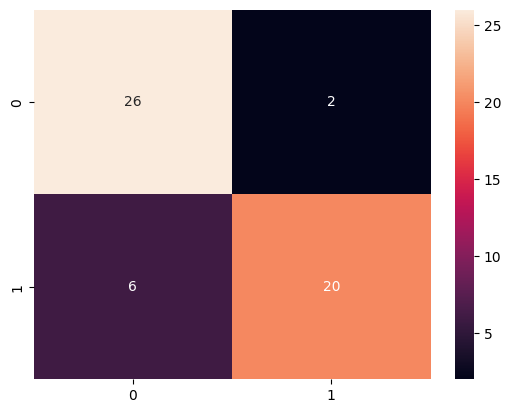

In [80]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

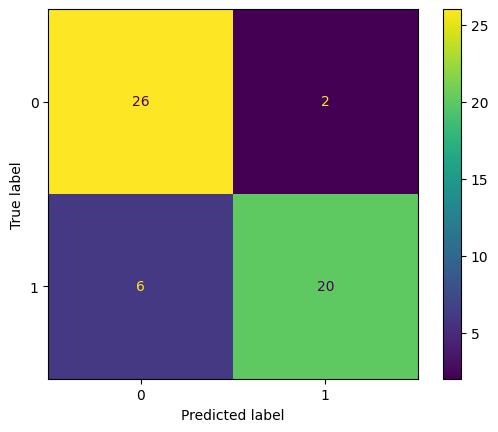

In [81]:
ConfusionMatrixDisplay.from_predictions(test_dataset.classes, predictions)

In [82]:
# The neural network can correctly identify 75% of the bart images and when it
# identifies these bart images, it is correct 68% of the time
# We can conclude that this neural network is better for classifying bart images, as
# we saw in the confusion matrix
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87        28
           1       0.91      0.77      0.83        26

    accuracy                           0.85        54
   macro avg       0.86      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



# Fine tuning

# Implementing

In [83]:
base_model.trainable = True

In [84]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x78a62e176aa0> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78a62e1e8f70> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a62e1e9270> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78a62e1e9f00> True
<keras.src.layers.core.activation.Activation object at 0x78a62e1e9780> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78a62e1eab90> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78a61f7341f0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a61f735ea0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78a61f735cf0> True
<keras.src.layers.core.activation.Activation object at 0x78a61f734130> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a61f7372b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 

In [85]:
len(base_model.layers)

175

In [86]:
fine_tuning_at = 140

In [87]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [88]:
CNN.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
history = CNN.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 12s 119ms/step - loss: 0.2548 - accuracy: 0.9256
Epoch 2/50
27/27 [==============================] - 5s 174ms/step - loss: 0.2954 - accuracy: 0.8744
Epoch 3/50
27/27 [==============================] - 3s 124ms/step - loss: 0.2163 - accuracy: 0.9395
Epoch 4/50
27/27 [==============================] - 3s 128ms/step - loss: 0.1572 - accuracy: 0.9395
Epoch 5/50
27/27 [==============================] - 4s 142ms/step - loss: 0.3299 - accuracy: 0.8791
Epoch 6/50
27/27 [==============================] - 3s 125ms/step - loss: 0.1343 - accuracy: 0.9488
Epoch 7/50
27/27 [==============================] - 3s 125ms/step - loss: 0.3081 - accuracy: 0.8837
Epoch 8/50
27/27 [==============================] - 4s 132ms/step - loss: 0.1087 - accuracy: 0.9535
Epoch 9/50
27/27 [==============================] - 3s 126ms/step - loss: 0.2934 - accuracy: 0.8744
Epoch 10/50
27/27 [==============================] - 3s 124ms/step - loss: 0.1303 - accuracy: 0.944

# Evaluate

In [47]:
predictions = CNN.predict(test_dataset)
predictions

54/54 [==============================] - 1s 11ms/step


array([[9.91621733e-01, 8.37833900e-03],
       [9.99061048e-01, 9.38913145e-04],
       [4.58628565e-05, 9.99954104e-01],
       [1.00000000e+00, 3.23373293e-08],
       [9.99114811e-01, 8.85204645e-04],
       [9.99982119e-01, 1.78557766e-05],
       [3.95061448e-02, 9.60493922e-01],
       [5.48699200e-01, 4.51300740e-01],
       [9.97424483e-01, 2.57551973e-03],
       [7.82014728e-01, 2.17985287e-01],
       [6.81210167e-07, 9.99999285e-01],
       [9.86853480e-01, 1.31465625e-02],
       [9.99993324e-01, 6.67133736e-06],
       [7.89072812e-01, 2.10927218e-01],
       [4.27461505e-01, 5.72538495e-01],
       [9.99990106e-01, 9.86268788e-06],
       [5.95669866e-01, 4.04330075e-01],
       [7.60865390e-01, 2.39134625e-01],
       [9.99996901e-01, 3.14109616e-06],
       [9.99999762e-01, 2.63997634e-07],
       [5.44779837e-01, 4.55220133e-01],
       [9.84877884e-01, 1.51220318e-02],
       [9.99990225e-01, 9.73399892e-06],
       [1.10101076e-02, 9.88989830e-01],
       [9.999973

In [48]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [49]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [90]:
accuracy_score(test_dataset.classes, predictions)

0.8518518518518519

# Saving and loading the model

In [91]:
model_json = CNN.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [92]:
from keras.models import save_model
network_saved = save_model(CNN, '/content/weights.hdf5')

<ipython-input-92-84eb2e7a60bd>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(CNN, '/content/weights.hdf5')


In [93]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, 256, 256, 3]}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initia

In [94]:
CNN_loaded = tf.keras.models.model_from_json(json_saved_model)
CNN_loaded.load_weights('weights.hdf5')
CNN_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [95]:
CNN_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Classifying one single image

In [100]:
img = cv2.imread('/content/homer_bart_2/test_set/homer/homer15.bmp')

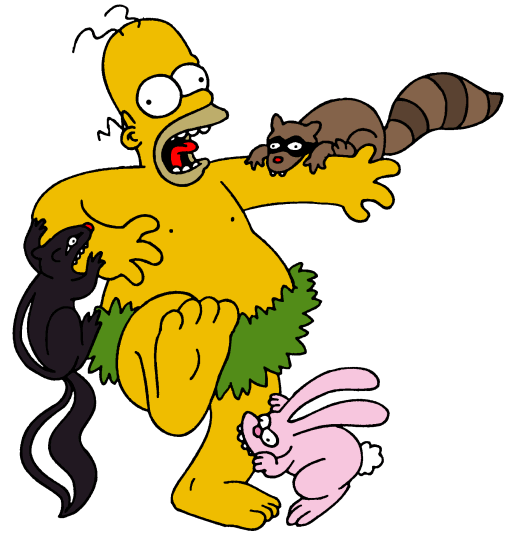

In [101]:
cv2_imshow(img)

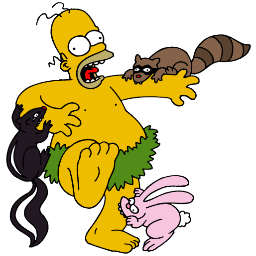

In [102]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
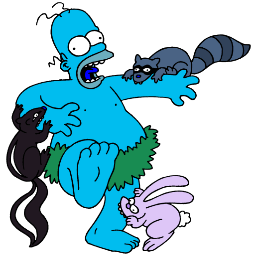

In [103]:
img

In [104]:
img = img / 255
img

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [105]:
img.shape

(256, 256, 3)

In [106]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [107]:
result = CNN_loaded(img)
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.28164333, 0.71835667]], dtype=float32)>

In [108]:
result = np.argmax(result)
result

1

In [109]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [110]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Homer
